<!-- # <p style="background-color:#FF7F50;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Importing Libraries</p> -->
# Importing Libraries

In [2]:
#Importing the Libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors

import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler,PowerTransformer
from sklearn.decomposition import PCA
from sklearn.mixture import BayesianGaussianMixture,GaussianMixture
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import metrics
import lightgbm as lgb
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")

<!-- # <p style="background-color:#FF7F50;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Loading Data</p> -->
# Loading Data

In [ ]:
df=pd.read_csv("./data.csv")
df=df.drop("id",axis=1)
ss=pd.read_csv("./sample_submission.csv")

<!-- # <p style="background-color:#FF7F50;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Confusion Matrix</p>
 -->
# Let's Look at correlation Heat Map

<Axes: >

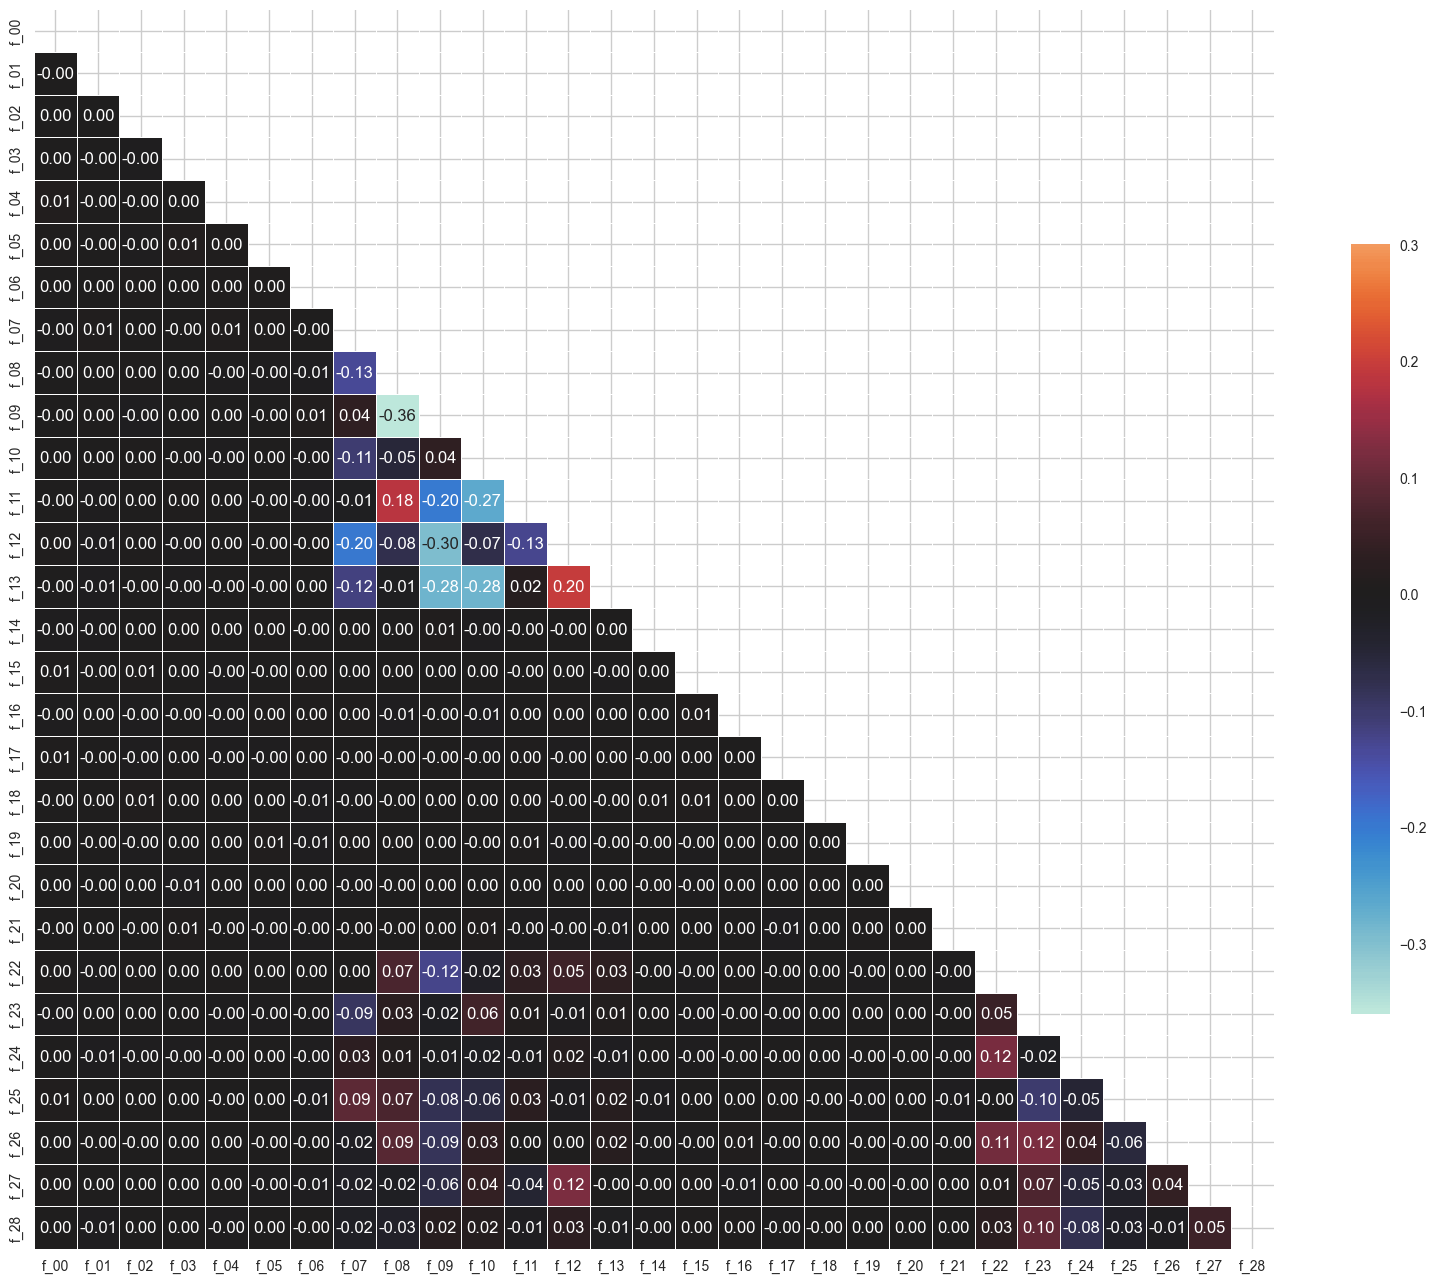

In [ ]:
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
f, ax = plt.subplots(figsize=(20,20))
sns.heatmap(df.corr(), mask=mask, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True,fmt='.2f')

<!-- [AmbrosM](https://www.kaggle.com/code/ambrosm/tpsjul22-gaussian-mixture-cluster-analysis) suggested some features are just not as useful as others.
> I'll be using all the integer features i.e from **(f_07, ... ,f_13)** & continuos features **(f_22 ,... ,f_28)**. -->

# Feature Selection
> This features are most important features, take a look in my other [kernel](https://www.kaggle.com/code/ashaykatrojwar/feature-selection-eda) to know more about `feature selection`.

In [ ]:
feats= ['f_07', 'f_08', 'f_09', 'f_10', 'f_11', 'f_12', 'f_13', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27', 'f_28']

<!-- # <p style="background-color:#FF7F50;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Scaling Data Data</p> -->
# Preprocessing Data 
> `Power Transformer` makes distribution more gaussian and is most appropriate for this competition.

In [ ]:
transformer = PowerTransformer()
X=transformer.fit_transform(df[feats])

# Dimensionality Reduction

In this problem, there are many factors on the basis of which the final classification will be done. These factors are basically attributes or features. The higher the number of features, the harder it is to work with it. Many of these features are correlated, and hence redundant. This is why I will be performing dimensionality reduction on the features before putting them through a classifier.
Dimensionality reduction is the process of reducing the number of random variables under consideration, by obtaining a set of principal variables.

`Principal component analysis (PCA)` is a technique for reducing the dimensionality of such datasets, increasing interpretability but at the same time minimizing information loss.

For this data, I will be reducing the dimensions to **`3`**.

In [ ]:
pca = PCA(n_components=3,random_state=1)
pca.fit(X)
PCA_ds = pd.DataFrame(pca.transform(df[feats]), columns=(["col1","col2","col3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,98000.0,-1.846882,6.183381,-21.181599,-6.112243,-2.777183,1.774114,27.772016
col2,98000.0,-1.322841,4.183491,-17.967360,-4.296643,-1.625981,1.480935,16.055424
col3,98000.0,-1.109548,4.178339,-17.550269,-3.979848,-1.173112,1.677173,15.872467


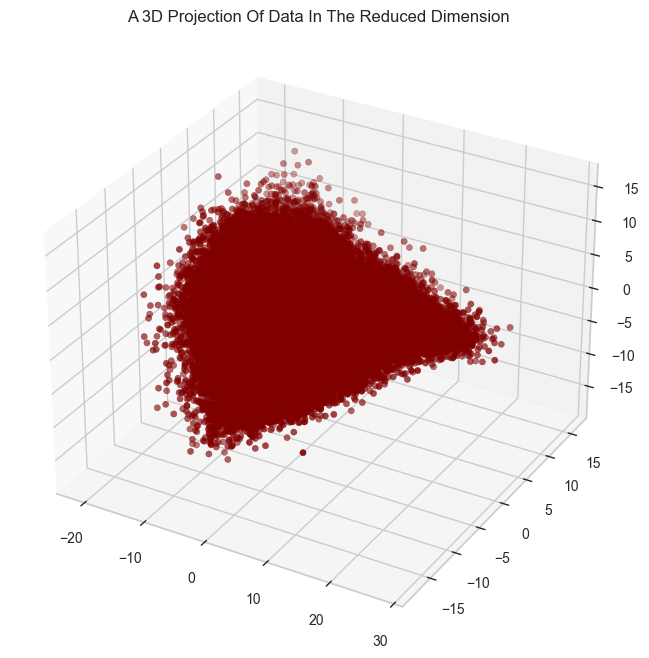

In [ ]:
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

# Elbow Method to determine optimum number of clusters to be formed:
> `7 clusters` gives the best results on leaderboard.

Elbow Method to determine the number of clusters to be formed:


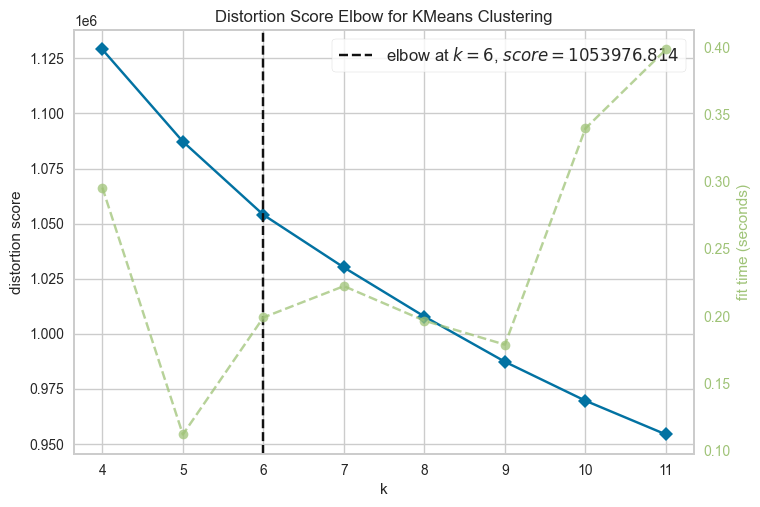

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(random_state=23), k=(4,12))
Elbow_M.fit(X)
Elbow_M.show()

# Bayesian Gaussian Mixture 

In [ ]:
BGM = BayesianGaussianMixture(n_components=7,covariance_type='full',random_state=1,n_init=15)
# fit model and predict clusters
preds = BGM.fit_predict(X)
PCA_ds["Clusters"] = preds
#Adding the Clusters feature to the orignal dataframe.
df["Clusters"]= preds


# Creating a classifier
> Training a LGBM model from the clusters predicted from Bayessian Gaussian Mixture

In [ ]:
pp=BGM.predict_proba(X)# Calcualting the probabilities of each prediction
df_new=pd.DataFrame(X,columns=feats) 
df_new[[f'predict_proba_{i}' for i in range(7)]]=pp # creating new dataframe columns of probabilites 
df_new['preds']=preds
df_new['predict_proba']=np.max(pp,axis=1)
df_new['predict']=np.argmax(pp,axis=1)
    
train_index=np.array([])
for n in range(7):
    n_inx=df_new[(df_new.preds==n) & (df_new.predict_proba > 0.68)].index
    train_index = np.concatenate((train_index, n_inx))

In [ ]:
#ricopue's notebook's code snippet
from sklearn.model_selection import StratifiedKFold
X_new=df_new.loc[train_index][feats]
y=df_new.loc[train_index]['preds']

params_lgb = {'learning_rate': 0.06,'objective': 'multiclass','boosting': 'gbdt','n_jobs': -1,'verbosity': -1, 'num_classes':7} 

model_list=[]

gkf = StratifiedKFold(11)
for fold, (train_idx, valid_idx) in enumerate(gkf.split(X_new,y)):   

    tr_dataset = lgb.Dataset(X_new.iloc[train_idx],y.iloc[train_idx],feature_name = feats)
    vl_dataset = lgb.Dataset(X_new.iloc[valid_idx],y.iloc[valid_idx],feature_name = feats)
    
    model = lgb.train(params = params_lgb, 
                train_set = tr_dataset, 
                valid_sets =  vl_dataset, 
                num_boost_round = 5000, 
                callbacks=[ lgb.early_stopping(stopping_rounds=300, verbose=False), lgb.log_evaluation(period=200)])  
    
    model_list.append(model) 

[200]	valid_0's multi_logloss: 0.0549042
[400]	valid_0's multi_logloss: 0.0321653
[600]	valid_0's multi_logloss: 0.0268725
[800]	valid_0's multi_logloss: 0.025232
[1000]	valid_0's multi_logloss: 0.0259355
[200]	valid_0's multi_logloss: 0.0475355
[400]	valid_0's multi_logloss: 0.0258259
[600]	valid_0's multi_logloss: 0.0209642
[800]	valid_0's multi_logloss: 0.0191248
[1000]	valid_0's multi_logloss: 0.0188537
[1200]	valid_0's multi_logloss: 0.0191414
[200]	valid_0's multi_logloss: 0.0524524
[400]	valid_0's multi_logloss: 0.0308886
[600]	valid_0's multi_logloss: 0.0255329
[800]	valid_0's multi_logloss: 0.0244537
[1000]	valid_0's multi_logloss: 0.0252485
[200]	valid_0's multi_logloss: 0.0553441
[400]	valid_0's multi_logloss: 0.0329521
[600]	valid_0's multi_logloss: 0.0278985
[800]	valid_0's multi_logloss: 0.0273624
[1000]	valid_0's multi_logloss: 0.0286241
[200]	valid_0's multi_logloss: 0.052867
[400]	valid_0's multi_logloss: 0.0297699
[600]	valid_0's multi_logloss: 0.0245674
[800]	valid_0

In [ ]:
lgb_preds=0
for model in model_list:
    lgb_preds+=model.predict(df_new[feats])

In [ ]:
labels=np.argmax(lgb_preds,axis=1)


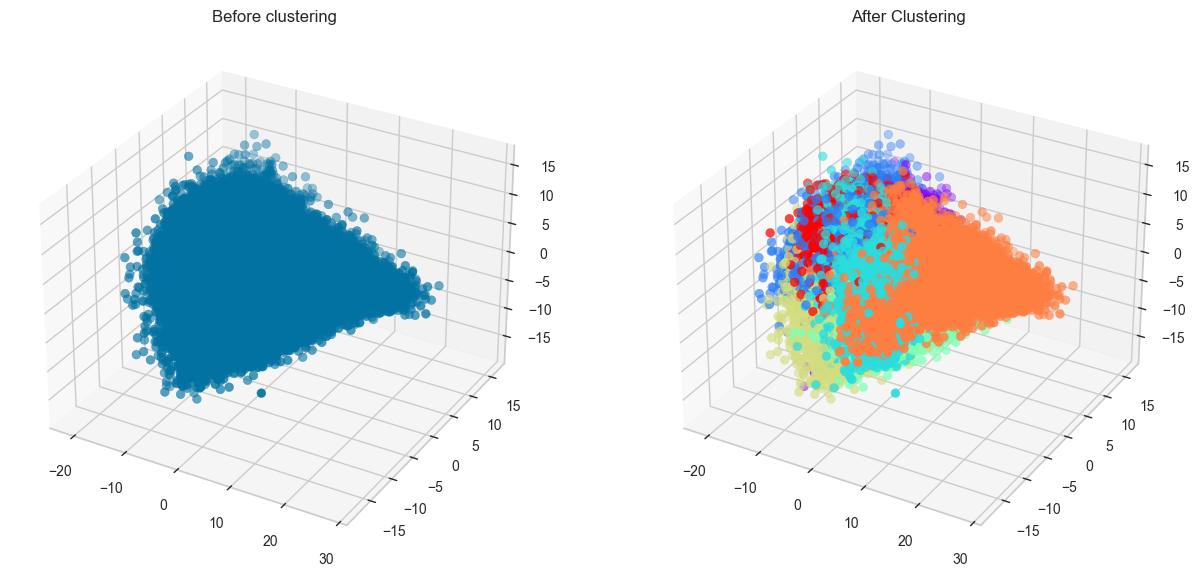

In [ ]:
fig = plt.figure(figsize=(15,8))
ax = plt.subplot(1,2,1, projection='3d', label="bla")
ax.scatter(PCA_ds['col1'],PCA_ds['col2'],PCA_ds['col3'], s=40, marker='o', cmap = 'rainbow' )
ax.set_title("Before clustering")
ax = plt.subplot(1,2,2, projection='3d', label="bla")
ax.scatter(PCA_ds['col1'],PCA_ds['col2'],PCA_ds['col3'], s=40, c=PCA_ds["Clusters"], marker='o',cmap="rainbow")
ax.set_title("After Clustering")
plt.show()


In [ ]:
ss.Predicted=np.argmax(lgb_preds,axis=1)

# Ploting the count plot for cluster distribution

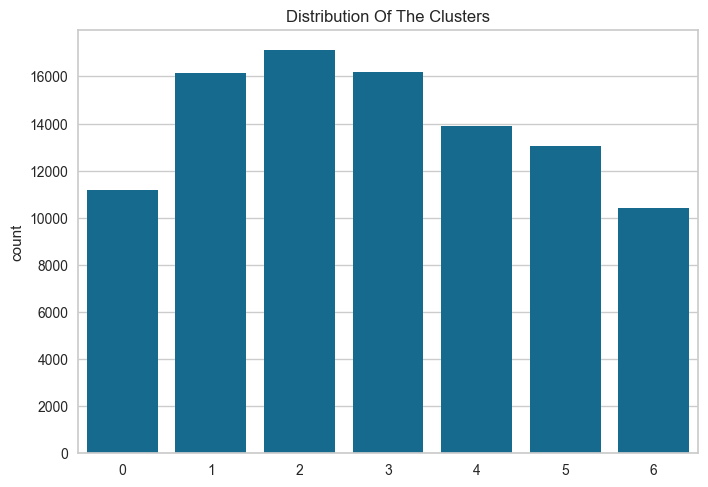

In [ ]:
pl = sns.countplot(x=np.argmax(lgb_preds,axis=1))
pl.set_title("Distribution Of The Clusters")
plt.show()

In [ ]:
ss.to_csv("submission.csv",index=False)

In [ ]:
print(2151260823% 12 )

3
